# Naive Bayes (Marketing Prediction)

## Penjelasan Kolom:

- User ID: Nomor identifikasi unik untuk setiap pengguna 
- Gender: Jenis kelamin pengguna (Male/Female) 
- Age: Usia pengguna (tahun) 
- EstimatedSalary: Perkiraan gaji tahunan pengguna (dalam satuan mata uang) 
- Purchased: Kolom target yang menunjukkan apakah pengguna melakukan pembelian (1) atau tidak (0)

### A. Data Preparation

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
try:
    df = pd.read_csv('marketing.csv')
    print("Berhasil membaca data")
except Exception as e:
    print("Gagal membaca data")

Berhasil membaca data


In [4]:
df.shape

(400, 5)

In [5]:
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510.0,Male,19.0,19000.0,0.0
1,15810944.0,Male,35.0,20000.0,0.0
2,15668575.0,Female,26.0,43000.0,0.0
3,15603246.0,Female,27.0,57000.0,0.0
4,15804002.0,Male,19.0,76000.0,0.0


In [6]:
df['Purchased'].unique()

array([0., 1.])

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.isna().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

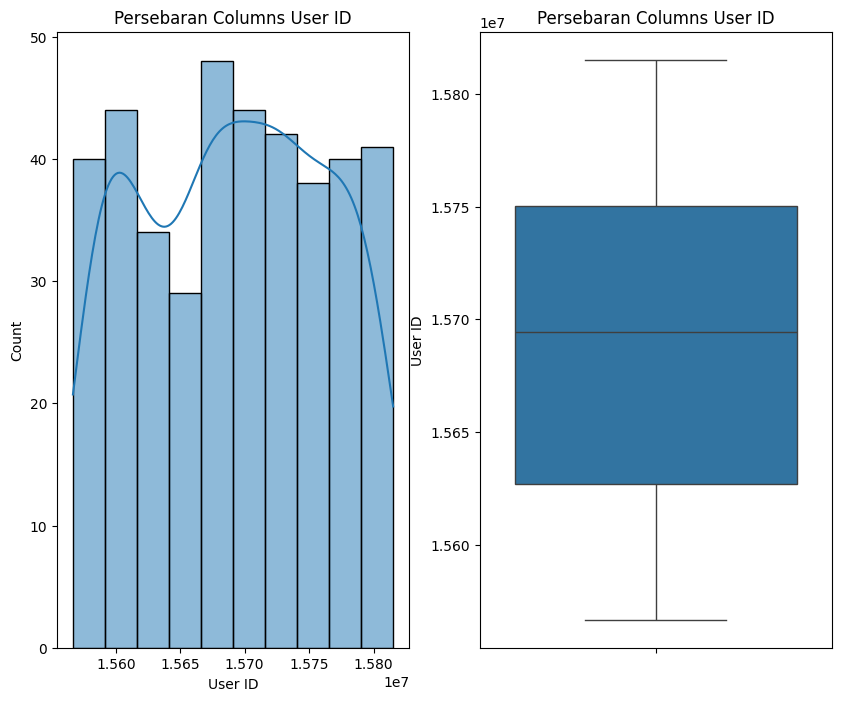

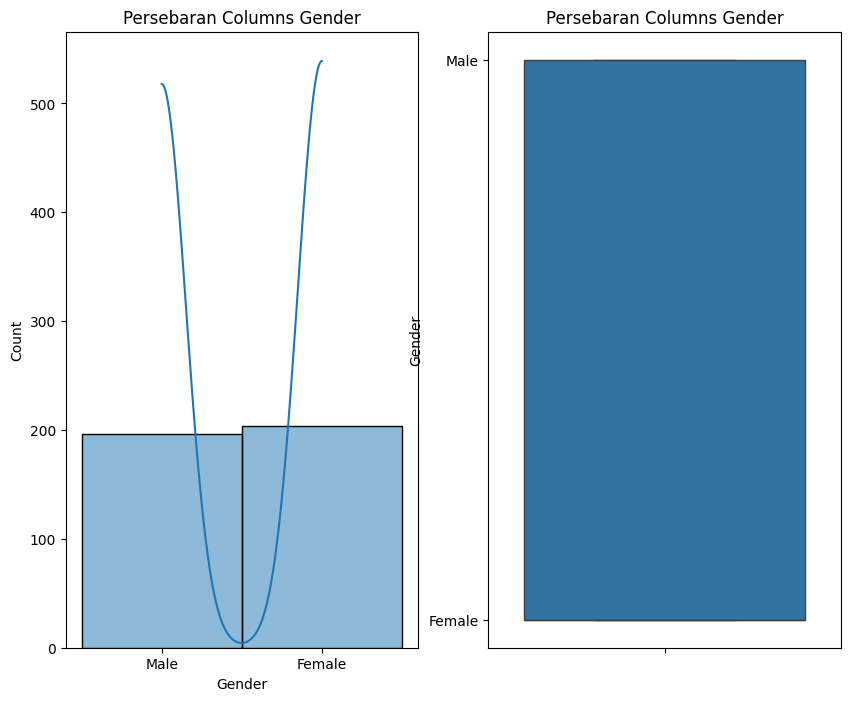

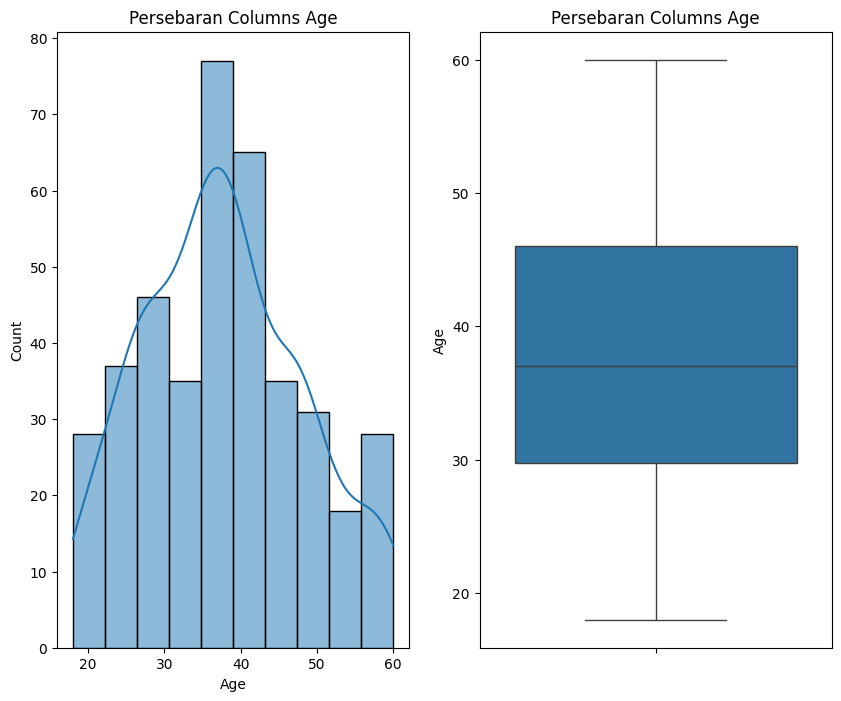

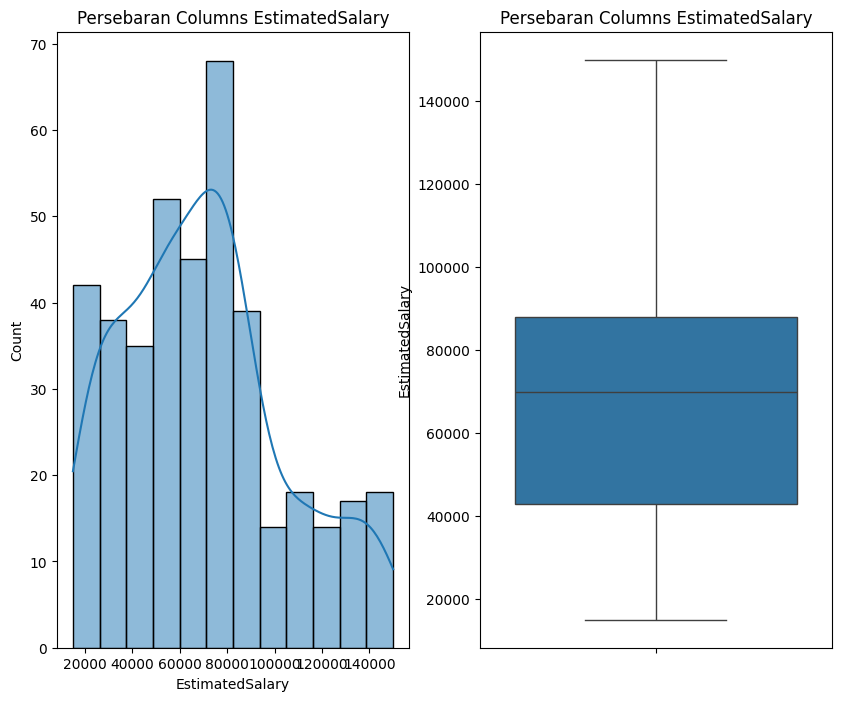

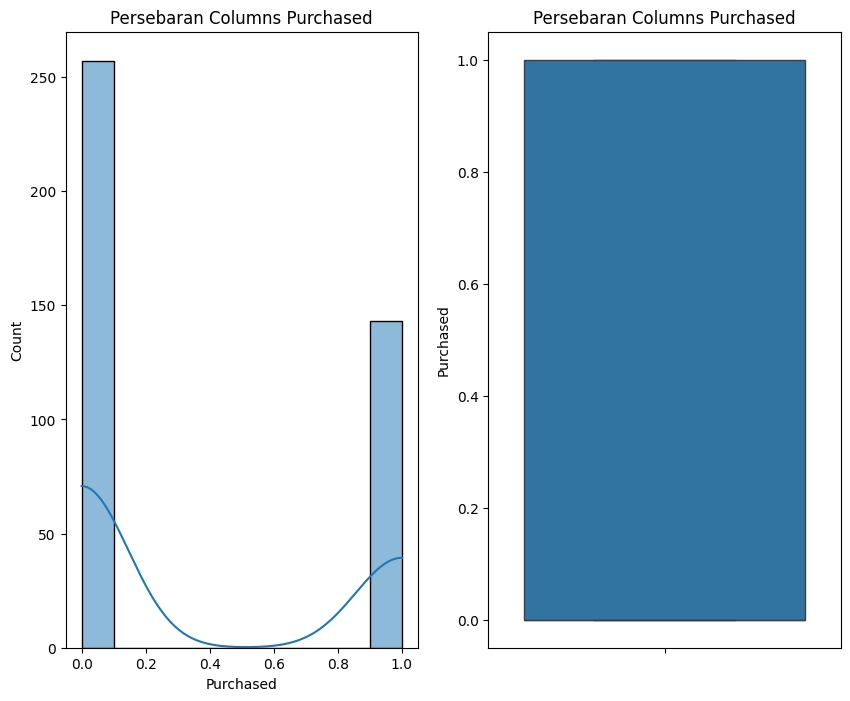

In [9]:
for col in df:
    fig, axes = plt.subplots(1,2, figsize=(10, 8))
    sns.histplot(df[col], ax=axes[0], kde=True)
    axes[0].set_title(f"Persebaran Columns {col}")
    
    sns.boxplot(df[col], ax=axes[1])
    axes[1].set_title(f"Persebaran Columns {col}")

In [10]:
df.describe().T.style.format("{:.2f}").background_gradient(cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
User ID,400.00,15691539.76,71658.32,15566689.00,15626763.75,15694341.50,15750363.00,15815236.00
Age,400.00,37.66,10.48,18.00,29.75,37.00,46.00,60.00
EstimatedSalary,400.00,69742.50,34096.96,15000.00,43000.00,70000.00,88000.00,150000.00
Purchased,400.00,0.36,0.48,0.00,0.00,0.00,1.00,1.00


### B. Data Preprocessing

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   User ID          400 non-null    float64
 1   Gender           400 non-null    object 
 2   Age              400 non-null    float64
 3   EstimatedSalary  400 non-null    float64
 4   Purchased        400 non-null    float64
dtypes: float64(4), object(1)
memory usage: 15.8+ KB


In [12]:
df['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [13]:
mapping_gender = {'Male' : 0,
                  'Female' : 1
}

df['Gender'] = df['Gender'].map(mapping_gender)

In [14]:
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510.0,0,19.0,19000.0,0.0
1,15810944.0,0,35.0,20000.0,0.0
2,15668575.0,1,26.0,43000.0,0.0
3,15603246.0,1,27.0,57000.0,0.0
4,15804002.0,0,19.0,76000.0,0.0


### C. Exploratory Data Analysis (EDA)

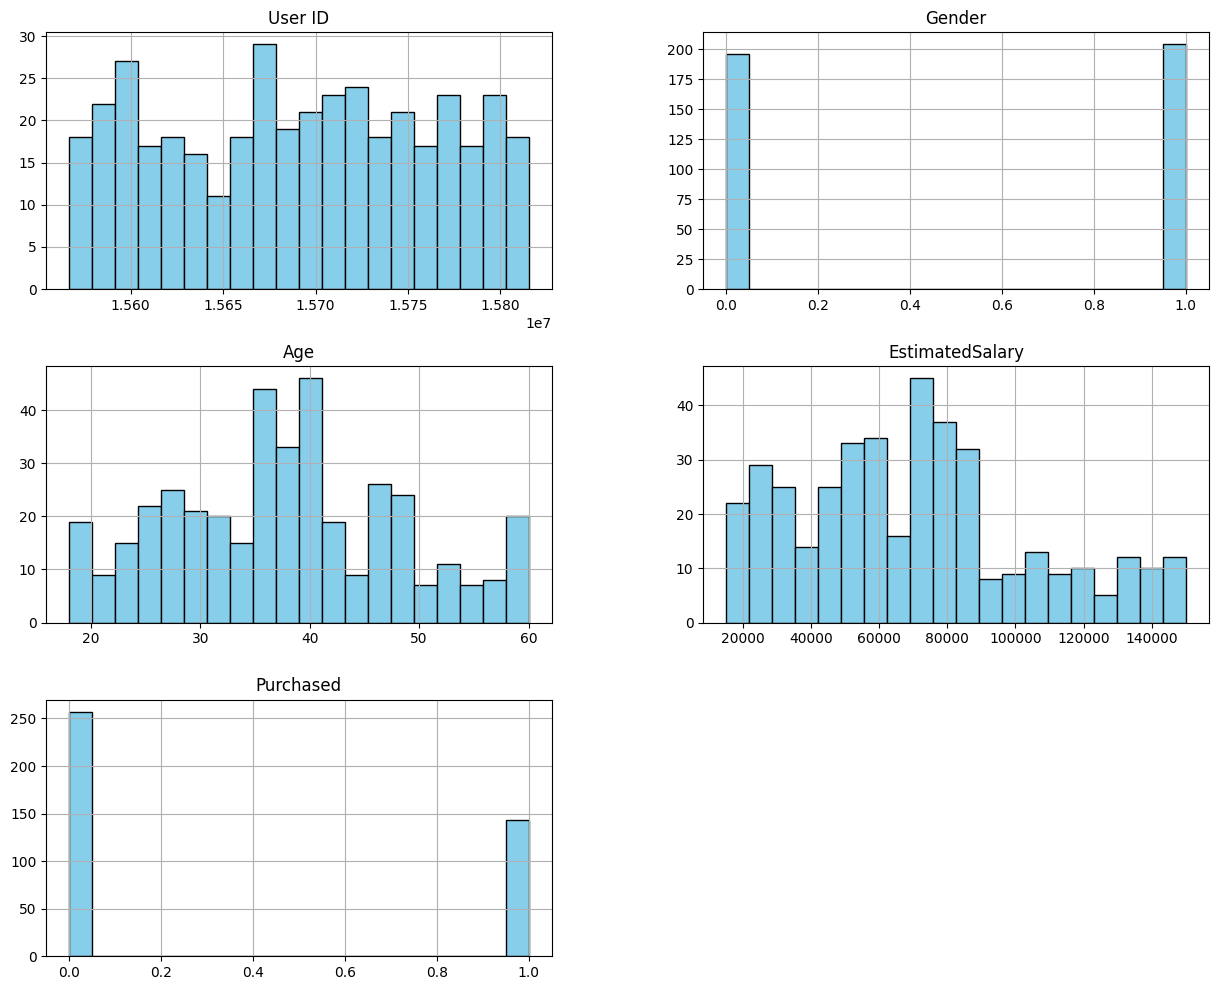

In [15]:
df.hist(bins=20, figsize=(15,12), color='skyblue', edgecolor='black')
plt.show()

In [16]:
df.skew()

User ID           -0.034513
Gender            -0.040159
Age                0.231337
EstimatedSalary    0.495024
Purchased          0.596903
dtype: float64

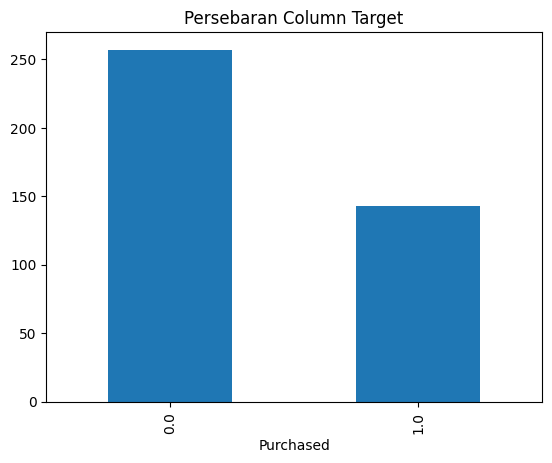

In [17]:
df['Purchased'].value_counts().plot(kind='bar').set_title("Persebaran Column Target")
plt.show()

In [18]:
df['Purchased'].value_counts(normalize=True)*100

Purchased
0.0    64.25
1.0    35.75
Name: proportion, dtype: float64

<Figure size 500x500 with 0 Axes>

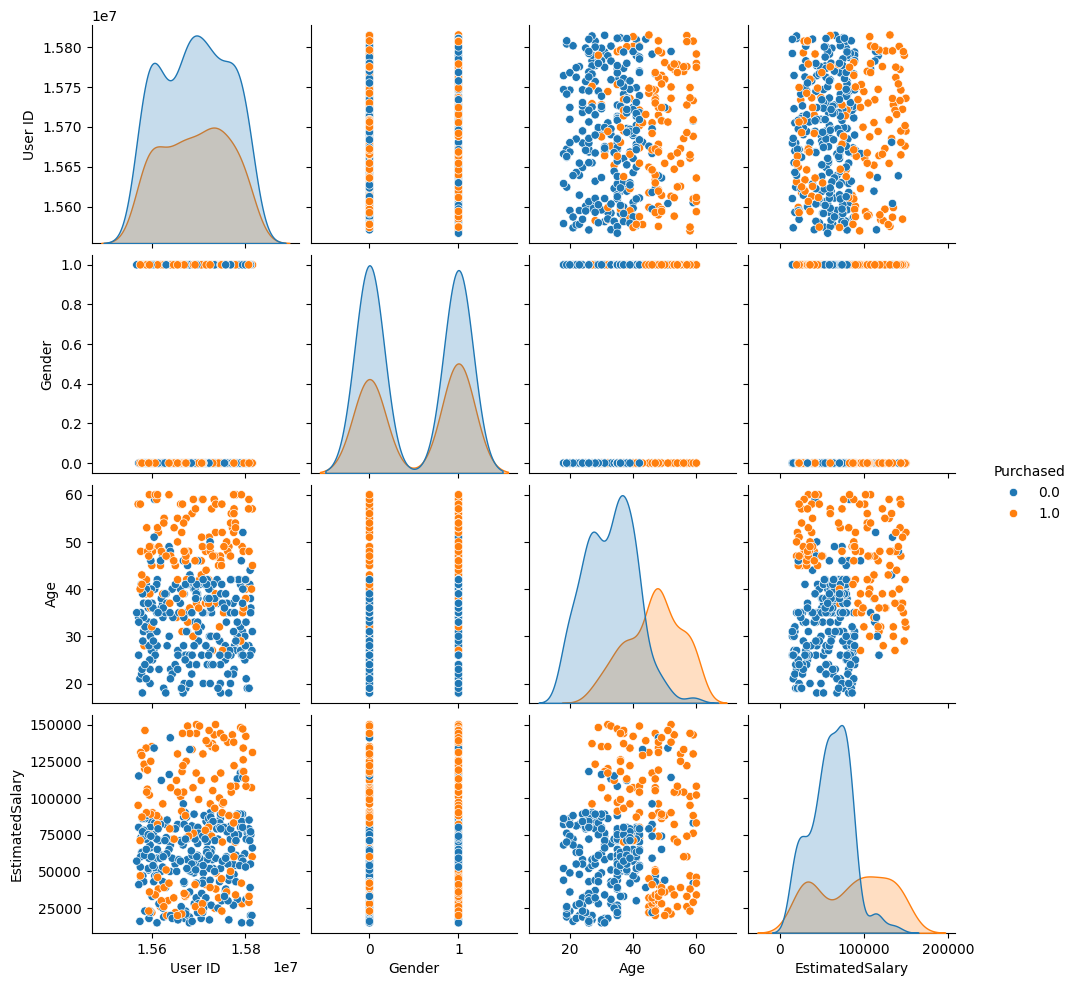

In [19]:
plt.figure(figsize=(5,5))
sns.pairplot(df, hue='Purchased')
plt.show()

In [20]:
df.describe().T.style.format("{:.2f}").background_gradient(cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
User ID,400.00,15691539.76,71658.32,15566689.00,15626763.75,15694341.50,15750363.00,15815236.00
Gender,400.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
Age,400.00,37.66,10.48,18.00,29.75,37.00,46.00,60.00
EstimatedSalary,400.00,69742.50,34096.96,15000.00,43000.00,70000.00,88000.00,150000.00
Purchased,400.00,0.36,0.48,0.00,0.00,0.00,1.00,1.00


<Axes: >

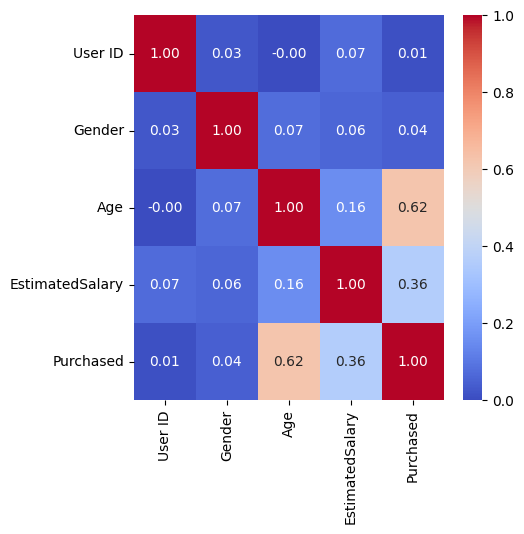

In [21]:
plt.figure(figsize=(5,5))
sns.heatmap(df.corr(),
            annot=True,
            fmt=".2f",
            cmap='coolwarm')

#### Resampling

In [22]:
df_major = df[df['Purchased'] == 0]
df_minor = df[df['Purchased'] == 1]

In [23]:
target_sample = (len(df_major))

In [24]:
df_minor_oversampled = df_minor.sample(n=target_sample, replace=True, random_state=42)

In [25]:
df_final = pd.concat([df_major, df_minor_oversampled])

In [26]:
df_final['Purchased'].value_counts()

Purchased
0.0    257
1.0    257
Name: count, dtype: int64

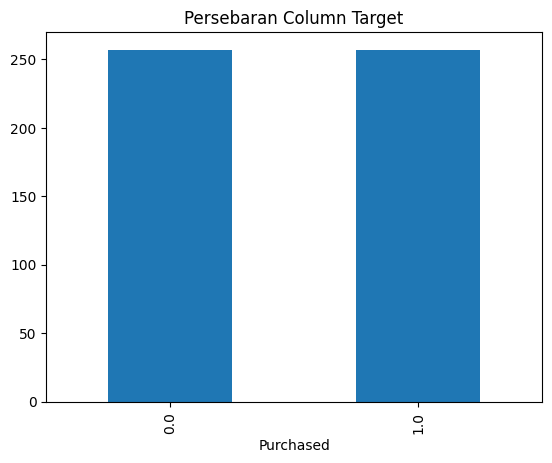

In [27]:
df_final['Purchased'].value_counts().plot(kind='bar').set_title("Persebaran Column Target")
plt.show()

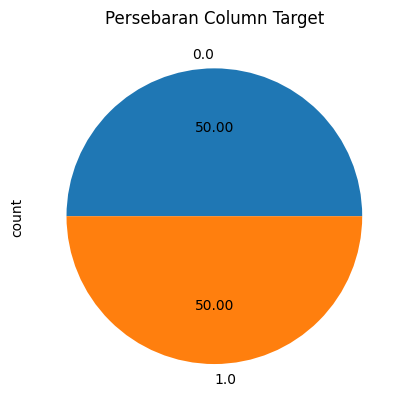

In [28]:
df_final['Purchased'].value_counts().plot(kind='pie', autopct='%.2f').set_title("Persebaran Column Target")
plt.show()

In [29]:
df_final.shape

(514, 5)

#### Normalisasi

In [30]:
feature = df_final.drop(columns='Purchased')
target = df_final['Purchased']

In [31]:
df_final_minmax = ((feature - feature.min()) / (feature.max() - feature.min()))

In [32]:
df_final_norm = pd.concat([df_final_minmax, target], axis=1)

In [33]:
df_final_norm.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,0.233030,0.0,0.023810,0.029630,0.0
1,0.984395,0.0,0.404762,0.037037,0.0
2,0.410620,1.0,0.190476,0.207407,0.0
3,0.147332,1.0,0.214286,0.311111,0.0
4,0.956417,0.0,0.023810,0.451852,0.0


### D. Modelling

In [34]:
df_final_norm.columns

Index(['User ID', 'Gender', 'Age', 'EstimatedSalary', 'Purchased'], dtype='object')

In [35]:
X = df_final_norm.drop(columns='Purchased')
y = df_final_norm['Purchased']

In [36]:
def stratified_split_data(X, y, train_size=0.8, random_state=42, frac=None):
    np.random.seed(random_state)
    
    if frac:
        X = X.sample(frac=frac, random_state=random_state)
        y = y.loc[X.index]
        
    X_train_list, X_test_list = [], []
    y_train_list, y_test_list = [], []
    
    for class_value in np.unique(y):
        class_idx = np.where(y == class_value)[0]
        
        idx = np.random.permutation(class_idx)
        split_ratio = int(len(idx) * train_size)
        
        X_train_list.append(X.iloc[idx[:split_ratio]])
        X_test_list.append(X.iloc[idx[split_ratio:]])
        y_train_list.append(y.iloc[idx[:split_ratio]])
        y_test_list.append(y.iloc[idx[split_ratio:]])
        
    X_train = pd.concat(X_train_list).reset_index(drop=True)
    X_test = pd.concat(X_test_list).reset_index(drop=True)
    y_train = pd.concat(y_train_list).reset_index(drop=True)
    y_test = pd.concat(y_test_list).reset_index(drop=True)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = stratified_split_data(X, y )

In [37]:
class NaiveBayes:
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)
        
        #menghitung mean, var, dan prior
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)
        
        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0)
            self._priors[idx] = X_c.shape[0] / float(n_samples)
            
    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)
    
    def _predict(self, x):
        posteriors = []
        
        #menghitung probabilitas posterior untuk setiap class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum(np.log(self._pdf(idx, x)))
            posterior = posterior + prior
            posteriors.append(posterior)
            
        return self._classes[np.argmax(posteriors)]
    
    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator
            

### E. Evaluasi Model

In [38]:
nb = NaiveBayes()
nb.fit(X_train.values, y_train.values)
predictions = nb.predict(X_test.values)
predictions

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

In [39]:
test_accuracy = np.sum(predictions == y_test)/len(X_test)
print(test_accuracy)

0.8846153846153846


In [40]:
predictions_train = nb.predict(X_train.values)

In [41]:
train_accuracy = np.sum(predictions_train == y_train)/len(X_train)
print(train_accuracy)

0.8780487804878049


In [42]:
def confusion_matrix(y_test, y_pred):
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    
    for asli, tebak in zip(y_test, y_pred):
        if asli == 1 and tebak == 1: TP += 1
        elif asli == 0 and tebak == 1: FP += 1
        elif asli == 1 and tebak == 0: FN += 1
        elif asli == 0 and tebak == 0: TN += 1
        
    return np.array([[TN, FP], [FN, TP]])

In [43]:
cm = confusion_matrix(y_test, predictions)
TP = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[0][0]

precision = TP / (TP + FP)
print(precision)

0.9


In [44]:
cm = confusion_matrix(y_test, predictions)
TP = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[0][0]

recall = TP / (TP + FN)
print(recall)

0.8653846153846154


In [45]:
fscore = 2*(precision*recall / precision+recall)
print(fscore)

3.4615384615384617


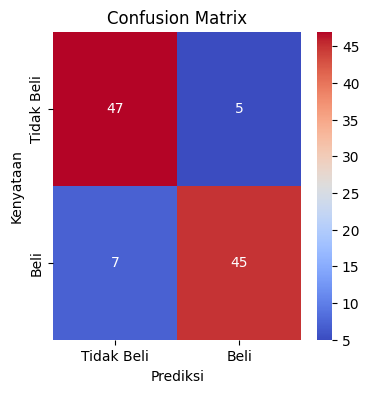

In [46]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Tidak Beli', 'Beli'], yticklabels=['Tidak Beli', 'Beli'])
plt.xlabel("Prediksi")
plt.ylabel("Kenyataan")
plt.title("Confusion Matrix")
plt.show()

In [47]:
df_final_norm.columns

Index(['User ID', 'Gender', 'Age', 'EstimatedSalary', 'Purchased'], dtype='object')

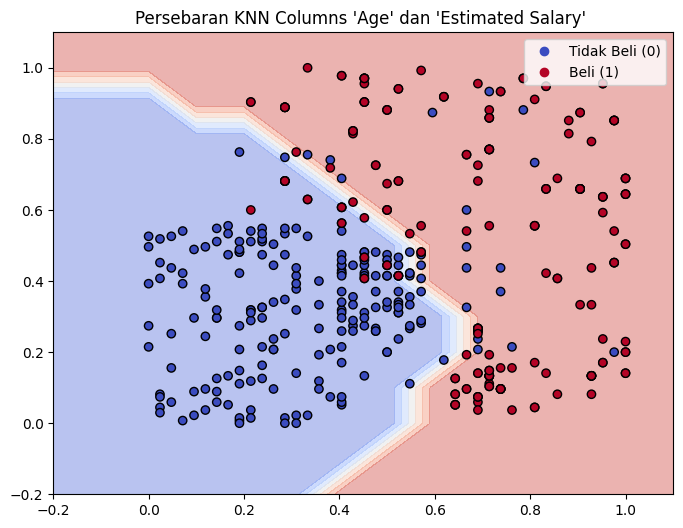

In [53]:
# mengambil column
x_mini = X_train.values[:, [2, 3]]
y_mini = y_train.values

# latih ulang model KNN Khusus Visualisasi
model_vis = NaiveBayes()
model_vis.fit(x_mini, y_mini)

# Bikin grid
x_min, x_max = x_mini[:, 0].min() - 0.2, x_mini[:, 0].max() + 0.2
y_min, y_max = x_mini[:, 1].min() - 0.2, x_mini[:, 1].max() + 0.2

# bikin titik kordinat
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Prediksi dan beri warna pada Grid
z = model_vis.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

# gambar 
plt.figure(figsize=(8, 6))

# beri grid warna floor warna coolwarm
plt.contourf(xx, yy, z, cmap='coolwarm', alpha=0.4)

# Gambar titik asli 
gambar = plt.scatter(x_mini[:, 0], x_mini[:, 1], c=y_mini, cmap='coolwarm', edgecolors='black')

plt.title("Persebaran KNN Columns 'Age' dan 'Estimated Salary' ")
plt.legend(handles = gambar.legend_elements()[0], labels = ['Tidak Beli (0)', 'Beli (1)' ], loc = "upper right")
plt.show()

### Kesimpulan / Insight
- Pola = Berdasarkan visualisasi data, orang yang berumur tinggi (tua) cenderung membeli produk dibandingkan orang yang berumur rendah (muda). Berdasarkan visualisasi data juga, orang yang estimasi gajinya tinggi cenderung membeli produk dibandingkan orang yang estimaasi gajinya rendah.
- Hubungan = Semakin tua seseorang (Age), dan semakin tinggi estimasi gajinya (Estimated Salary) akan lebih besar peluang untuk membeli produknya
- Hipotesis = Dapat melakukan promosi atau iklan kepada orang-orang tua dan orang-orang yang estimasi gajinya tinggi agar meningkatkan penjualan